<a href="https://colab.research.google.com/github/BelalMJ/DM-Project---CS-63015-001/blob/main/RFM_ML_Models_Group5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
# CELL 1: Setup Project Structure
import numpy as np
np.random.seed(42) #  Reproducibility setup
from google.colab import drive
drive.mount('/content/drive')

# Create project folders
PROJECT_DIR = "/content/drive/MyDrive/rfm_ml_project"
!mkdir -p "$PROJECT_DIR/data" "$PROJECT_DIR/src" "$PROJECT_DIR/output/models" "$PROJECT_DIR/output/plots" "$PROJECT_DIR/output/metrics"

print("✅ Project structure created!")
!ls -la "$PROJECT_DIR"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Project structure created!
total 12
drwx------ 2 root root 4096 Nov 22 15:40 data
drwx------ 5 root root 4096 Nov 22 15:40 output
drwx------ 3 root root 4096 Nov 22 15:38 src


In [73]:
# CELL 2: Upload Dataset
from google.colab import files
import shutil
import os

PROJECT_DIR = "/content/drive/MyDrive/rfm_ml_project"

print("📤 Please select the online_retail_II.xlsx file from your computer:")
uploaded = files.upload()

# Move to correct location
for filename in uploaded.keys():
    shutil.move(filename, f"{PROJECT_DIR}/data/{filename}")
    print(f"✅ Moved {filename} to {PROJECT_DIR}/data/")

# Verify
print("\n📁 Files in data directory:")
print(os.listdir(f"{PROJECT_DIR}/data"))

📤 Please select the online_retail_II.xlsx file from your computer:



📁 Files in data directory:
['online_retail_II.xlsx', 'cleaned_2009_2010.csv', 'cleaned_2010_2011.csv', 'labels_2009_2010_to_2010_2011.csv', 'rfm_2009_2010.csv']


In [74]:
# CELL 3: Install Required Packages
!pip install pandas numpy scikit-learn matplotlib seaborn joblib openpyxl xgboost --quiet
print("✅ All packages installed!")

✅ All packages installed!


In [75]:
# CELL 4: Create Data Preprocessing Script
PROJECT_SRC = "/content/drive/MyDrive/rfm_ml_project/src"

data_preprocessing_code = '''import os
import pandas as pd

INPUT_XLSX = "data/online_retail_II.xlsx"
SHEET_1 = "Year 2009-2010"
SHEET_2 = "Year 2010-2011"
OUTPUT_DIR = "data"

def clean_transactions(df, keep_country="United Kingdom"):
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]

    # Normalize column names
    if 'Customer ID' in df.columns:
        df.rename(columns={'Customer ID': 'CustomerID'}, inplace=True)
    if 'InvoiceNo' in df.columns:
        df.rename(columns={'InvoiceNo': 'Invoice'}, inplace=True)
    if 'Invoice Number' in df.columns:
        df.rename(columns={'Invoice Number': 'Invoice'}, inplace=True)

    # Using normalized names
    if 'CustomerID' in df.columns:
        df = df.dropna(subset=['CustomerID'])
        df['CustomerID'] = pd.to_numeric(df['CustomerID'], errors='coerce').dropna().astype(int)
    if 'Invoice' in df.columns:
        df = df[~df['Invoice'].astype(str).str.startswith('C', na=False)]
    if 'Quantity' in df.columns:
        df = df[df['Quantity'] > 0]
    if 'InvoiceDate' in df.columns:
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    if 'Quantity' in df.columns and 'Price' in df.columns:
        df['TotalPrice'] = df['Quantity'] * df['Price']
    if 'Country' in df.columns and keep_country:
        df = df[df['Country'] == keep_country]

    keep_cols = ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'CustomerID', 'Country', 'TotalPrice']
    existing = [c for c in keep_cols if c in df.columns]
    return df[existing]

def main():
    xlsx_path = os.path.join("data", "online_retail_II.xlsx")
    xls = pd.ExcelFile(xlsx_path)
    df1 = pd.read_excel(xlsx_path, sheet_name=SHEET_1)
    df2 = pd.read_excel(xlsx_path, sheet_name=SHEET_2)
    clean1 = clean_transactions(df1)
    clean2 = clean_transactions(df2)
    os.makedirs("data", exist_ok=True)
    clean1.to_csv(os.path.join("data","cleaned_2009_2010.csv"), index=False)
    clean2.to_csv(os.path.join("data","cleaned_2010_2011.csv"), index=False)
    print("✅ Saved cleaned CSVs to data/")

if __name__ == "__main__":
    main()
'''

with open(f"{PROJECT_SRC}/data_preprocessing.py", "w") as f:
    f.write(data_preprocessing_code)

print("✅ data_preprocessing.py created!")

✅ data_preprocessing.py created!


In [76]:
# CELL 5: Create RFM Builder Script
rfm_builder_code = '''import os, argparse
import pandas as pd

def compute_rfm(df, ref_date=None):
    df = df.copy()
    if ref_date is None:
        ref_date = df['InvoiceDate'].max()
    else:
        ref_date = pd.to_datetime(ref_date)
    grouped = df.groupby('CustomerID').agg(
        Recency = ('InvoiceDate', lambda x: (ref_date - x.max()).days),
        Frequency = ('Invoice', pd.Series.nunique),
        Monetary = ('TotalPrice', 'sum')
    ).reset_index()
    grouped['Monetary'] = grouped['Monetary'].fillna(0.0)
    return grouped

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("input_csv")
    parser.add_argument("output_csv")
    parser.add_argument("--ref_date", default=None)
    args = parser.parse_args()
    df = pd.read_csv(args.input_csv, parse_dates=['InvoiceDate'])
    rfm = compute_rfm(df, ref_date=args.ref_date)
    os.makedirs(os.path.dirname(args.output_csv) or ".", exist_ok=True)
    rfm.to_csv(args.output_csv, index=False)
    print("✅ Saved RFM to", args.output_csv)

if __name__ == "__main__":
    main()
'''

with open(f"{PROJECT_SRC}/rfm_builder.py", "w") as f:
    f.write(rfm_builder_code)

print("✅ rfm_builder.py created!")

✅ rfm_builder.py created!


In [77]:
# CELL 6: Create Label Engineering Script
label_engineering_code = '''import pandas as pd
import argparse
import os

def create_labels(period_a_csv, period_b_csv, output_csv):
    df_a = pd.read_csv(period_a_csv)
    df_b = pd.read_csv(period_b_csv)

    customers_a = df_a['CustomerID'].unique()
    customers_b = df_b['CustomerID'].unique()

    labels = pd.DataFrame({'CustomerID': customers_a})
    labels['WillPurchaseNext'] = labels['CustomerID'].isin(customers_b).astype(int)

    os.makedirs(os.path.dirname(output_csv) or ".", exist_ok=True)
    labels.to_csv(output_csv, index=False)
    print("✅ Saved labels to", output_csv)

def main():  # ADD THIS MISSING FUNCTION
    parser = argparse.ArgumentParser()
    parser.add_argument("period_a_csv")
    parser.add_argument("period_b_csv")
    parser.add_argument("output_csv")
    args = parser.parse_args()
    create_labels(args.period_a_csv, args.period_b_csv, args.output_csv)

if __name__ == "__main__":
    main()
'''

with open(f"{PROJECT_SRC}/label_engineering.py", "w") as f:
    f.write(label_engineering_code)

In [78]:
# CELL 7: Create Model Dataset Builder
model_dataset_code = '''import os, argparse
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def build_dataset(rfm_csv, labels_csv, output_dir, test_size=0.3, random_state=42):
    os.makedirs(output_dir, exist_ok=True)
    rfm = pd.read_csv(rfm_csv)
    labels = pd.read_csv(labels_csv)
    df = pd.merge(rfm, labels, on='CustomerID', how='left')
    df['WillPurchaseNext'] = df['WillPurchaseNext'].fillna(0).astype(int)
    df['Monetary_log'] = (df['Monetary'] + 1).apply(lambda x: np.log(x))
    features = ['Recency', 'Frequency', 'Monetary_log']
    X = df[features]
    y = df['WillPurchaseNext']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)
    X_train.to_csv(os.path.join(output_dir, "X_train.csv"), index=False)
    X_test.to_csv(os.path.join(output_dir, "X_test.csv"), index=False)
    y_train.to_csv(os.path.join(output_dir, "y_train.csv"), index=False)
    y_test.to_csv(os.path.join(output_dir, "y_test.csv"), index=False)
    df.to_csv(os.path.join(output_dir, "model_dataset_full.csv"), index=False)
    print("✅ Saved dataset files to", output_dir)

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("rfm_csv")
    parser.add_argument("labels_csv")
    parser.add_argument("output_dir")
    args = parser.parse_args()
    build_dataset(args.rfm_csv, args.labels_csv, args.output_dir)

if __name__ == "__main__":
    main()
'''

with open(f"{PROJECT_SRC}/model_dataset_builder.py", "w") as f:
    f.write(model_dataset_code)

print("✅ model_dataset_builder.py created!")

✅ model_dataset_builder.py created!


In [79]:
# CELL 8: Create Model Training Script
train_models_code = '''import os, argparse, joblib
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def load_data(X_path, y_path):
    X = pd.read_csv(X_path)
    y = pd.read_csv(y_path).squeeze()
    return X, y

def train_and_save(X_train, y_train, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    models = {}

    # Logistic Regression
    pipe_lr = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(max_iter=500, random_state=42))])
    pipe_lr.fit(X_train, y_train)
    models['logistic'] = pipe_lr
    joblib.dump(pipe_lr, os.path.join(output_dir, 'logistic.pkl'))

    # Random Forest
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    models['random_forest'] = rf
    joblib.dump(rf, os.path.join(output_dir, 'random_forest.pkl'))

    # XGBoost - FIXED: Added missing comma
    xgb = XGBClassifier(
        n_estimators=200,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False,  # ADDED COMMA HERE
        subsample=1.0,
        colsample_bytree=1.0
    )
    xgb.fit(X_train, y_train)
    models['xgboost'] = xgb
    joblib.dump(xgb, os.path.join(output_dir, 'xgboost.pkl'))

    print("✅ Trained and saved models:", list(models.keys()))
    return models

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("X_train")
    parser.add_argument("y_train")
    parser.add_argument("output_dir", default="output/models")
    args = parser.parse_args()
    X_train, y_train = load_data(args.X_train, args.y_train)
    train_and_save(X_train, y_train, args.output_dir)

if __name__ == "__main__":
    main()
'''

with open(f"{PROJECT_SRC}/train_baseline_models.py", "w") as f:
    f.write(train_models_code)

print("✅ train_baseline_models.py created!")

✅ train_baseline_models.py created!


In [80]:
# CELL 9: Create Evaluation Framework
evaluation_framework_code = '''import os, pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, precision_recall_curve, auc)

class ModelEvaluator:
    def __init__(self, models, X_test, y_test, feature_names=None):
        self.models = models
        self.X_test = X_test
        self.y_test = y_test
        self.feature_names = feature_names or X_test.columns.tolist()
        self.results = {}

    def evaluate_single_model(self, model, model_name):
        y_pred = model.predict(self.X_test)
        try:
            y_proba = model.predict_proba(self.X_test)[:, 1]
        except Exception:
            if hasattr(model, "decision_function"):
                y_proba = model.decision_function(self.X_test)
            else:
                y_proba = y_pred
        metrics = {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred, zero_division=0),
            'recall': recall_score(self.y_test, y_pred, zero_division=0),
            'f1': f1_score(self.y_test, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(self.y_test, y_proba) if len(np.unique(self.y_test))>1 else np.nan,
            'y_pred': y_pred,
            'y_proba': y_proba
        }
        self.results[model_name] = metrics
        return metrics

    def compare_models(self):
        rows = {}
        for name, model in self.models.items():
            m = self.evaluate_single_model(model, name)
            rows[name] = {k: v for k, v in m.items() if k in ['accuracy','precision','recall','f1','roc_auc']}
        return pd.DataFrame(rows).T

    def plot_roc_curves(self, outpath=None):
        plt.figure(figsize=(8,6))
        for name, res in self.results.items():
            y_proba = res['y_proba']
            fpr, tpr, _ = roc_curve(self.y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
        plt.plot([0,1],[0,1],'k--', alpha=0.3)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(loc='lower right')
        if outpath:
            os.makedirs(os.path.dirname(outpath) or ".", exist_ok=True)
            plt.savefig(outpath, bbox_inches='tight')
        plt.show()

    def plot_pr_curves(self, outpath=None):
        plt.figure(figsize=(8,6))
        for name, res in self.results.items():
            y_proba = res['y_proba']
            precision, recall, _ = precision_recall_curve(self.y_test, y_proba)
            pr_auc = auc(recall, precision)
            plt.plot(recall, precision, label=f"{name} (AUC = {pr_auc:.3f})")
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves')
        plt.legend(loc='lower left')
        if outpath:
            os.makedirs(os.path.dirname(outpath) or ".", exist_ok=True)
            plt.savefig(outpath, bbox_inches='tight')
        plt.show()

    def save_confusion_matrices(self, outdir="output/plots"):
        os.makedirs(outdir, exist_ok=True)
        for name, res in self.results.items():
            cm = confusion_matrix(self.y_test, res['y_pred'])
            fig, ax = plt.subplots(figsize=(4,3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
            ax.set_title(f'Confusion Matrix: {name}')
            fig.savefig(os.path.join(outdir, f"confusion_{name}.png"), bbox_inches='tight')
            plt.close(fig)

    def feature_importance(self, model_name, outpath=None):
        model = self.models[model_name]
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_).ravel()
        else:
            raise ValueError("Model has no feature_importances_ or coef_")
        fi = pd.DataFrame({'feature': self.feature_names, 'importance': importances})
        fi = fi.sort_values('importance', ascending=False)
        if outpath:
            os.makedirs(os.path.dirname(outpath) or ".", exist_ok=True)
            fi.to_csv(outpath, index=False)
        return fi
'''

with open(f"{PROJECT_SRC}/evaluation_framework.py", "w") as f:
    f.write(evaluation_framework_code)

print("✅ evaluation_framework.py created!")

✅ evaluation_framework.py created!


In [81]:
# CELL 10: Create Statistical Analysis Script
statistical_analysis_code = '''import numpy as np
from scipy import stats

def paired_t_test(scores_model_1, scores_model_2, alpha=0.05):
    scores_model_1 = np.array(scores_model_1)
    scores_model_2 = np.array(scores_model_2)
    t_stat, p_value = stats.ttest_rel(scores_model_1, scores_model_2, nan_policy='omit')
    significant = p_value < alpha
    return t_stat, p_value, significant
'''

with open(f"{PROJECT_SRC}/statistical_analysis.py", "w") as f:
    f.write(statistical_analysis_code)

print("✅ statistical_analysis.py created!")

✅ statistical_analysis.py created!


In [82]:
# CELL 11: Create Business Metrics Script
business_metrics_code = '''import numpy as np
import pandas as pd

def lift_curve(y_true, y_proba, n_bins=10):
    df = pd.DataFrame({'y_true': y_true, 'y_proba': y_proba})
    df = df.sort_values('y_proba', ascending=False).reset_index(drop=True)
    df['decile'] = pd.qcut(df.index, q=n_bins, labels=False, duplicates='drop')
    agg = df.groupby('decile').agg(
        n=('y_true','count'),
        positives=('y_true','sum'),
        avg_proba=('y_proba','mean')
    ).reset_index()
    total_rate = df['y_true'].sum() / len(df)
    agg['response_rate'] = agg['positives'] / agg['n']
    agg['lift'] = agg['response_rate'] / total_rate
    return agg.sort_values('decile')

def topk_capture_rate(y_true, y_proba, k=0.1):
    df = pd.DataFrame({'y_true': y_true, 'y_proba': y_proba})
    df = df.sort_values('y_proba', ascending=False)
    cutoff = max(1, int(len(df) * k))  # Ensure at least 1 sample
    top = df.head(cutoff)
    if df['y_true'].sum() == 0:
        return 0.0
    return top['y_true'].sum() / df['y_true'].sum()

def gains_table(y_true, y_proba, n_bins=10):
    agg = lift_curve(y_true, y_proba, n_bins=n_bins)
    agg['cumulative_positives'] = agg['positives'].cumsum()
    agg['cumulative_percent_positives'] = agg['cumulative_positives'] / agg['positives'].sum()
    agg['cumulative_percent_population'] = ((agg['decile']+1) * (1.0/n_bins)).values
    return agg
'''

with open(f"{PROJECT_SRC}/business_metrics.py", "w") as f:
    f.write(business_metrics_code)

print("✅ business_metrics.py created!")

✅ business_metrics.py created!


In [83]:
# CELL 12: Create Visualization Script
visualization_code = '''import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_model_metrics_table(results_df, outpath=None):
    fig, ax = plt.subplots(figsize=(10, 1+0.5*len(results_df)))
    sns.heatmap(results_df, annot=True, fmt=".3f", cmap="YlGnBu", cbar=False, ax=ax)
    ax.set_title("Model Performance Metrics")
    if outpath:
        os.makedirs(os.path.dirname(outpath) or ".", exist_ok=True)
        fig.savefig(outpath, bbox_inches='tight')
    plt.show()

def plot_roc(models_results, y_test, outpath=None):
    plt.figure(figsize=(8,6))
    for name, res in models_results.items():
        fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
    plt.plot([0,1],[0,1],'k--', alpha=0.3)
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves'); plt.legend(loc='lower right')
    if outpath:
        os.makedirs(os.path.dirname(outpath) or ".", exist_ok=True)
        plt.savefig(outpath, bbox_inches='tight')
    plt.show()

def plot_lift(agg, outpath=None):
    plt.figure(figsize=(8,5))
    plt.plot(agg['decile']+1, agg['lift'], marker='o')
    plt.xlabel('Decile (1=top)'); plt.ylabel('Lift'); plt.title('Lift by Decile')
    if outpath:
        os.makedirs(os.path.dirname(outpath) or ".", exist_ok=True)
        plt.savefig(outpath, bbox_inches='tight')
    plt.show()
'''

with open(f"{PROJECT_SRC}/results_visualization.py", "w") as f:
    f.write(visualization_code)

print("✅ results_visualization.py created!")

# Create __init__.py
with open(f"{PROJECT_SRC}/__init__.py", "w") as f:
    f.write("# Package initialization\n")

print("✅ __init__.py created for proper imports!")

✅ results_visualization.py created!
✅ __init__.py created for proper imports!


In [84]:
# CELL 13: Verify All Files Created
PROJECT_SRC = "/content/drive/MyDrive/rfm_ml_project/src"
print("📁 All source files created:")
!ls -la "$PROJECT_SRC"

📁 All source files created:
total 21
-rw------- 1 root root 1361 Nov 22 15:58 business_metrics.py
-rw------- 1 root root 2109 Nov 22 15:58 data_preprocessing.py
-rw------- 1 root root 4409 Nov 22 15:58 evaluation_framework.py
-rw------- 1 root root   25 Nov 22 15:58 __init__.py
-rw------- 1 root root  923 Nov 22 15:58 label_engineering.py
-rw------- 1 root root 1463 Nov 22 15:58 model_dataset_builder.py
drwx------ 2 root root 4096 Nov 22 15:05 __pycache__
-rw------- 1 root root 1527 Nov 22 15:58 results_visualization.py
-rw------- 1 root root 1053 Nov 22 15:58 rfm_builder.py
-rw------- 1 root root  362 Nov 22 15:58 statistical_analysis.py
-rw------- 1 root root 1849 Nov 22 15:58 train_baseline_models.py


In [85]:
# CELL 14: Run Data Preprocessing
print("🔄 Step 1: Running data preprocessing...")
%cd /content/drive/MyDrive/rfm_ml_project
!python3 src/data_preprocessing.py

print("\n📊 Checking output files:")
!ls -lh data/

🔄 Step 1: Running data preprocessing...
/content/drive/MyDrive/rfm_ml_project
✅ Saved cleaned CSVs to data/

📊 Checking output files:
total 111M
-rw------- 1 root root 35M Nov 22 16:00 cleaned_2009_2010.csv
-rw------- 1 root root 33M Nov 22 16:00 cleaned_2010_2011.csv
-rw------- 1 root root 32K Nov 22 15:40 labels_2009_2010_to_2010_2011.csv
-rw------- 1 root root 44M Nov 21 14:06 online_retail_II.xlsx
-rw------- 1 root root 78K Nov 22 15:40 rfm_2009_2010.csv


In [86]:
# CELL 15: Build RFM Features
print("🔄 Step 2: Building RFM features...")
%cd /content/drive/MyDrive/rfm_ml_project
!python3 src/rfm_builder.py data/cleaned_2009_2010.csv data/rfm_2009_2010.csv --ref_date 2010-12-31

print("\n📊 Checking RFM file:")
!ls -lh data/rfm_2009_2010.csv

🔄 Step 2: Building RFM features...
/content/drive/MyDrive/rfm_ml_project
✅ Saved RFM to data/rfm_2009_2010.csv

📊 Checking RFM file:
-rw------- 1 root root 78K Nov 22 16:00 data/rfm_2009_2010.csv


In [87]:
# CELL 16: Create Labels
print("🔄 Step 3: Creating labels...")
%cd /content/drive/MyDrive/rfm_ml_project
!python3 src/label_engineering.py data/cleaned_2009_2010.csv data/cleaned_2010_2011.csv data/labels_2009_2010_to_2010_2011.csv

print("\n📊 Checking labels file:")
!ls -lh data/labels_2009_2010_to_2010_2011.csv

🔄 Step 3: Creating labels...
/content/drive/MyDrive/rfm_ml_project
✅ Saved labels to data/labels_2009_2010_to_2010_2011.csv

📊 Checking labels file:
-rw------- 1 root root 32K Nov 22 16:00 data/labels_2009_2010_to_2010_2011.csv


In [88]:
# CELL 17: Build Modeling Dataset
print("🔄 Step 4: Building modeling dataset...")
%cd /content/drive/MyDrive/rfm_ml_project
!python3 src/model_dataset_builder.py data/rfm_2009_2010.csv data/labels_2009_2010_to_2010_2011.csv output

print("\n📊 Checking output files:")
!ls -lh output/

🔄 Step 4: Building modeling dataset...
/content/drive/MyDrive/rfm_ml_project
✅ Saved dataset files to output

📊 Checking output files:
total 264K
drwx------ 2 root root 4.0K Nov 22 15:40 metrics
-rw------- 1 root root 153K Nov 22 16:00 model_dataset_full.csv
drwx------ 2 root root 4.0K Nov 22 15:40 models
drwx------ 2 root root 4.0K Nov 22 15:40 plots
-rw------- 1 root root  28K Nov 22 16:00 X_test.csv
-rw------- 1 root root  64K Nov 22 16:00 X_train.csv
-rw------- 1 root root 2.4K Nov 22 16:00 y_test.csv
-rw------- 1 root root 5.5K Nov 22 16:00 y_train.csv


In [89]:
# CELL 18: Train Baseline Models
print("🔄 Step 5: Training baseline models...")
%cd /content/drive/MyDrive/rfm_ml_project
!python3 src/train_baseline_models.py output/X_train.csv output/y_train.csv output/models

print("\n📊 Checking trained models:")
!ls -lh output/models/

🔄 Step 5: Training baseline models...
/content/drive/MyDrive/rfm_ml_project
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:00:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
✅ Trained and saved models: ['logistic', 'random_forest', 'xgboost']

📊 Checking trained models:
total 19M
-rw------- 1 root root 1.7K Nov 22 16:00 logistic.pkl
-rw------- 1 root root  19M Nov 22 16:00 random_forest.pkl
-rw------- 1 root root 423K Nov 22 16:00 xgboost.pkl


In [90]:
# CELL 19: Run Complete Evaluation
print("🔄 Step 6: Running complete evaluation...")
import joblib, pandas as pd, os
from src.evaluation_framework import ModelEvaluator
from src.results_visualization import plot_roc, plot_lift
from src.business_metrics import lift_curve, topk_capture_rate

proj = "/content/drive/MyDrive/rfm_ml_project"

# Load models
print("📥 Loading trained models...")
models = {
    'logistic': joblib.load(os.path.join(proj, "output/models/logistic.pkl")),
    'random_forest': joblib.load(os.path.join(proj, "output/models/random_forest.pkl")),
    'xgboost': joblib.load(os.path.join(proj, "output/models/xgboost.pkl"))
}


# Load test data
print("📥 Loading test data...")
X_test = pd.read_csv(os.path.join(proj, "output/X_test.csv"))
y_test = pd.read_csv(os.path.join(proj, "output/y_test.csv")).squeeze()

# Initialize evaluator
print("🔬 Evaluating models...")
e = ModelEvaluator(models, X_test, y_test)

# Compare models
res_df = e.compare_models()
print("\n" + "="*70)
print("📊 MODEL PERFORMANCE COMPARISON")
print("="*70)
print(res_df)

# Save performance table
os.makedirs(os.path.join(proj, "output/metrics"), exist_ok=True)
res_df.to_csv(os.path.join(proj, "output/metrics/performance_table.csv"))
print(f"\n✅ Saved performance table to: output/metrics/performance_table.csv")

🔄 Step 6: Running complete evaluation...
📥 Loading trained models...
📥 Loading test data...
🔬 Evaluating models...

📊 MODEL PERFORMANCE COMPARISON
               accuracy  precision    recall        f1   roc_auc
logistic       0.736577   0.757471  0.864829  0.807598  0.798541
random_forest  0.723993   0.770287  0.809711  0.789507  0.782409
xgboost        0.710570   0.760300  0.799213  0.779271  0.775322

✅ Saved performance table to: output/metrics/performance_table.csv


🎨 Generating visualizations...


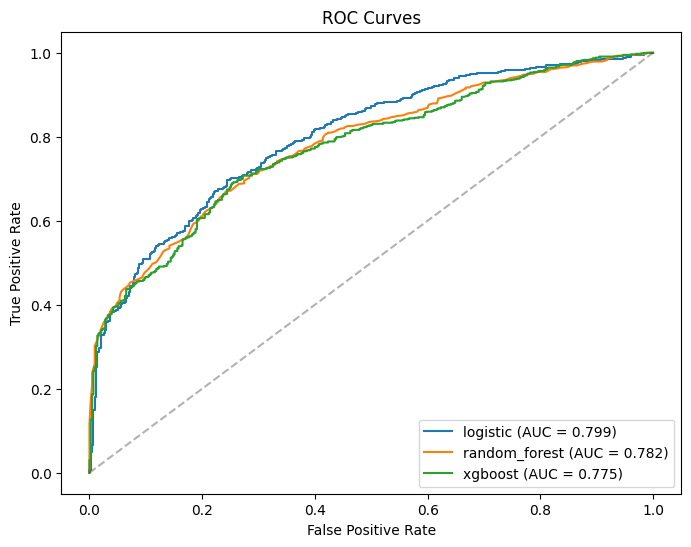

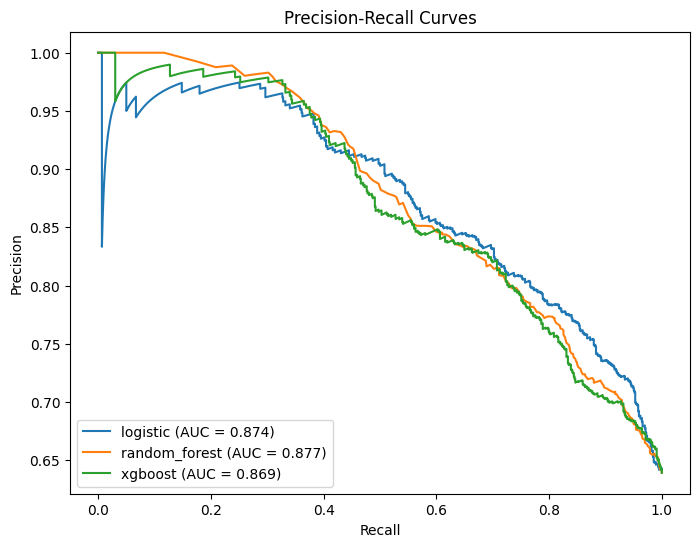


🔍 COMPLETE Feature importance comparison:
Random Forest:
        feature  importance
2  Monetary_log    0.474731
0       Recency    0.399223
1     Frequency    0.126046

XGBoost:
        feature  importance
1     Frequency    0.583864
0       Recency    0.239271
2  Monetary_log    0.176865

Logistic Regression:
        feature  importance  coefficient
1     Frequency    1.066998     1.066998
2  Monetary_log    0.562475     0.562475
0       Recency    0.513439    -0.513439

📈 Business Metrics (Best Model: logistic):
Top 10% capture rate: 0.151
Lift in top decile: 1.512


In [91]:
# CELL 20: Generate Visualizations
import numpy as np
import pandas as pd
print("🎨 Generating visualizations...")

# ROC and PR curves for all 3 models
e.plot_roc_curves(os.path.join(proj, "output/plots/roc_3models.png"))
e.plot_pr_curves(os.path.join(proj, "output/plots/pr_3models.png"))

# Confusion matrices for all 3 models
e.save_confusion_matrices(os.path.join(proj, "output/plots"))

# Feature importance for ALL THREE models
fi_rf = e.feature_importance('random_forest', outpath=os.path.join(proj,"output/metrics/feature_importance_rf.csv"))
fi_xgb = e.feature_importance('xgboost', outpath=os.path.join(proj,"output/metrics/feature_importance_xgb.csv"))

# ADD LOGISTIC REGRESSION FEATURE IMPORTANCE
def get_logistic_importance(model, feature_names):
    """Extract feature importance from Logistic Regression using coefficients"""
    # Find the step with coefficients (fallback method)
    if hasattr(model, 'named_steps'):
        lr_step = None
        for name, step in model.named_steps.items():
            if hasattr(step, 'coef_'):
                lr_step = step
                break
        if lr_step is None:
            raise ValueError("No model with coefficients found in pipeline")
        coefficients = np.abs(lr_step.coef_[0])
        actual_coefficients = lr_step.coef_[0]
    elif hasattr(model, 'coef_'):
        coefficients = np.abs(model.coef_[0])
        actual_coefficients = model.coef_[0]
    else:
        raise ValueError("Cannot extract coefficients from this model type")

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': coefficients,
        'coefficient': actual_coefficients
    }).sort_values('importance', ascending=False)
    return importance_df

# Get Logistic Regression importance
lr_model = models['logistic']
feature_names = X_test.columns.tolist()
fi_lr = get_logistic_importance(lr_model, feature_names)
fi_lr.to_csv(os.path.join(proj, "output/metrics/feature_importance_lr.csv"), index=False)

print("\n🔍 COMPLETE Feature importance comparison:")
print("Random Forest:")
print(fi_rf)
print("\nXGBoost:")
print(fi_xgb)
print("\nLogistic Regression:")
print(fi_lr)

# Business metrics using the BEST model
best_model_name = res_df['roc_auc'].idxmax()
best_proba = e.results[best_model_name]['y_proba']

agg = lift_curve(y_test, best_proba, n_bins=10)
agg.to_csv(os.path.join(proj, "output/metrics/lift_best_model.csv"), index=False)
capture_rate = topk_capture_rate(y_test, best_proba, k=0.1)

print(f"\n📈 Business Metrics (Best Model: {best_model_name}):")
print(f"Top 10% capture rate: {capture_rate:.3f}")
print(f"Lift in top decile: {agg.iloc[0]['lift']:.3f}")


In [92]:
# CELL 21: Statistical Significance Testing
print("📊 Running statistical significance tests...")
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np
from src.statistical_analysis import paired_t_test

# Load training data
X_train = pd.read_csv(os.path.join(proj, "output/X_train.csv"))
y_train = pd.read_csv(os.path.join(proj, "output/y_train.csv")).squeeze()

# Cross-validation scores
print("Running 5-fold cross-validation for 3 models...")
lr = LogisticRegression(max_iter=500, random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
xgb = XGBClassifier(n_estimators=200, random_state=42, eval_metric='logloss', use_label_encoder=False, subsample=1.0, colsample_bytree=1.0)

scores_lr = cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
scores_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
scores_xgb = cross_val_score(xgb, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

print(f"CV AUC - Logistic Regression: {scores_lr.mean():.3f} (+/- {scores_lr.std() * 2:.3f})")
print(f"CV AUC - Random Forest:       {scores_rf.mean():.3f} (+/- {scores_rf.std() * 2:.3f})")
print(f"CV AUC - XGBoost:             {scores_xgb.mean():.3f} (+/- {scores_xgb.std() * 2:.3f})")

# Statistical tests between all pairs
print(f"\n📋 Statistical Significance Tests:")
t_lr_rf, p_lr_rf, sig_lr_rf = paired_t_test(scores_lr, scores_rf)
t_lr_xgb, p_lr_xgb, sig_lr_xgb = paired_t_test(scores_lr, scores_xgb)
t_rf_xgb, p_rf_xgb, sig_rf_xgb = paired_t_test(scores_rf, scores_xgb)

print(f"LR vs RF:   t = {t_lr_rf:.3f}, p = {p_lr_rf:.3f}, significant: {sig_lr_rf}")
print(f"LR vs XGB:  t = {t_lr_xgb:.3f}, p = {p_lr_xgb:.3f}, significant: {sig_lr_xgb}")
print(f"RF vs XGB:  t = {t_rf_xgb:.3f}, p = {p_rf_xgb:.3f}, significant: {sig_rf_xgb}")

# Save comprehensive statistical results
stats_results = pd.DataFrame({
    'model': ['logistic_regression', 'random_forest', 'xgboost'],
    'cv_mean_auc': [scores_lr.mean(), scores_rf.mean(), scores_xgb.mean()],
    'cv_std_auc': [scores_lr.std(), scores_rf.std(), scores_xgb.std()],
    'best_final_model': [res_df.loc['logistic', 'roc_auc'], res_df.loc['random_forest', 'roc_auc'], res_df.loc['xgboost', 'roc_auc']]
})
stats_results.to_csv(os.path.join(proj, "output/metrics/statistical_results_3models.csv"), index=False)
print("✅ Saved statistical results to output/metrics/statistical_results_3models.csv")

📊 Running statistical significance tests...
Running 5-fold cross-validation for 3 models...
CV AUC - Logistic Regression: 0.791 (+/- 0.030)
CV AUC - Random Forest:       0.780 (+/- 0.020)
CV AUC - XGBoost:             0.766 (+/- 0.011)

📋 Statistical Significance Tests:
LR vs RF:   t = 1.468, p = 0.216, significant: False
LR vs XGB:  t = 3.141, p = 0.035, significant: True
RF vs XGB:  t = 4.463, p = 0.011, significant: True
✅ Saved statistical results to output/metrics/statistical_results_3models.csv


In [93]:
# CELL 22: Final Deliverables Check
print("🎯 FINAL DELIVERABLES CHECKLIST")
print("="*60)

proj = "/content/drive/MyDrive/rfm_ml_project"
deliverables = {
    "Data Files": [
        "data/cleaned_2009_2010.csv",
        "data/cleaned_2010_2011.csv",
        "data/rfm_2009_2010.csv",
        "data/labels_2009_2010_to_2010_2011.csv"
    ],
    "Modeling Data": [
        "output/X_train.csv",
        "output/X_test.csv",
        "output/y_train.csv",
        "output/y_test.csv",
        "output/model_dataset_full.csv"
    ],
    "Trained Models (3)": [
        "output/models/logistic.pkl",
        "output/models/random_forest.pkl",
        "output/models/xgboost.pkl"
    ],
    "Evaluation Metrics": [
        "output/metrics/performance_table.csv",
        "output/metrics/feature_importance_rf.csv",
        "output/metrics/feature_importance_xgb.csv",
        "output/metrics/lift_best_model.csv",
        "output/metrics/statistical_results_3models.csv"
    ],
    "Visualizations": [
        "output/plots/roc_3models.png",
        "output/plots/pr_3models.png",
        "output/plots/confusion_logistic.png",
        "output/plots/confusion_random_forest.png",
        "output/plots/confusion_xgboost.png"
    ]
}

for category, files in deliverables.items():
    print(f"\n{category}:")
    for file in files:
        full_path = os.path.join(proj, file)
        if os.path.exists(full_path):
            print(f"  ✅ {file}")
        else:
            print(f"  ❌ {file} - MISSING")

print("\n" + "="*60)
print("🎉 3-MODEL PIPELINE EXECUTION COMPLETE!")
print("📊 Now comparing: Logistic Regression, Random Forest, AND XGBoost")
print("📁 All deliverables are in: /content/drive/MyDrive/rfm_ml_project/")

🎯 FINAL DELIVERABLES CHECKLIST

Data Files:
  ✅ data/cleaned_2009_2010.csv
  ✅ data/cleaned_2010_2011.csv
  ✅ data/rfm_2009_2010.csv
  ✅ data/labels_2009_2010_to_2010_2011.csv

Modeling Data:
  ✅ output/X_train.csv
  ✅ output/X_test.csv
  ✅ output/y_train.csv
  ✅ output/y_test.csv
  ✅ output/model_dataset_full.csv

Trained Models (3):
  ✅ output/models/logistic.pkl
  ✅ output/models/random_forest.pkl
  ✅ output/models/xgboost.pkl

Evaluation Metrics:
  ✅ output/metrics/performance_table.csv
  ✅ output/metrics/feature_importance_rf.csv
  ✅ output/metrics/feature_importance_xgb.csv
  ✅ output/metrics/lift_best_model.csv
  ✅ output/metrics/statistical_results_3models.csv

Visualizations:
  ✅ output/plots/roc_3models.png
  ✅ output/plots/pr_3models.png
  ✅ output/plots/confusion_logistic.png
  ✅ output/plots/confusion_random_forest.png
  ✅ output/plots/confusion_xgboost.png

🎉 3-MODEL PIPELINE EXECUTION COMPLETE!
📊 Now comparing: Logistic Regression, Random Forest, AND XGBoost
📁 All delive

In [95]:
# CELL 23: Download Key Results
print("📥 Downloading key results to your computer...")
from google.colab import files

key_files = [
    "output/metrics/performance_table.csv",
    "output/metrics/feature_importance_rf.csv",
    "output/plots/roc_3models.png",
    "output/plots/pr_3models.png"
]

for file in key_files:
    full_path = os.path.join(proj, file)
    if os.path.exists(full_path):
        files.download(full_path)
        print(f"✅ Downloaded: {file}")
    else:
        print(f"❌ File not found: {file}")

print("All Model Evaluation and Metric have successfully delivered!")

📥 Downloading key results to your computer...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: output/metrics/performance_table.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: output/metrics/feature_importance_rf.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: output/plots/roc_3models.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: output/plots/pr_3models.png
All Model Evaluation and Metric have successfully delivered!
